# Linear Regression to Predict Student Performance

<div class="alert alert-block alert-info">

authors, group info, project info

</dic>

Our selected dataset is [Student Performance Factors](https://www.kaggle.com/datasets/lainguyn123/student-performance-factors).

All of the scripts and data for this project can be found on our [Git Repository](https://github.com/cztm/linear-regression).

In [62]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from plotnine import *
import scipy.stats as stats
from statsmodels.stats.outliers_influence import OLSInfluence



## Introduction: about our data

<div class="alert alert-block alert-danger">

_To compelete_

</div>

In [4]:
students = pd.read_csv("StudentPerformanceFactors.csv")

## EDA

### First sniff of the data

In [5]:
print(f"Our dataset has {students.shape[1]} variables and {students.shape[0]} records")

Our dataset has 20 variables and 6607 records


In [6]:
students.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [7]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

### Variable types

In [8]:
object_cols = []
numeric_cols = []
for colname in students.columns:
    type = students[colname].dtype
    if type == "int64":
        numeric_cols.append(colname)
    elif type == "object":
        object_cols.append(colname)

In [9]:
print(f"Object columns: {object_cols}")
print(f"Numeric columns: {numeric_cols}")

Object columns: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Numeric columns: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score']


In [10]:
unique_values = students.nunique()
unique_values

Hours_Studied                 41
Attendance                    41
Parental_Involvement           3
Access_to_Resources            3
Extracurricular_Activities     2
Sleep_Hours                    7
Previous_Scores               51
Motivation_Level               3
Internet_Access                2
Tutoring_Sessions              9
Family_Income                  3
Teacher_Quality                3
School_Type                    2
Peer_Influence                 3
Physical_Activity              7
Learning_Disabilities          2
Parental_Education_Level       3
Distance_from_Home             3
Gender                         2
Exam_Score                    45
dtype: int64

<div class="alert alert-block alert-warning">

A lot of our variables, even though numerical, could be looked at more in a categorical sense since they're discrete and have a very limited number of unique values.

</div>

In [11]:
turn_categorical = []
for col in numeric_cols:
    if unique_values[col] < 10:
        print(f"{col} has {unique_values[col]} unique values")
        turn_categorical.append(col)

Sleep_Hours has 7 unique values
Tutoring_Sessions has 9 unique values
Physical_Activity has 7 unique values


Let's turn these columns into categorical values.

In [12]:
students[turn_categorical] = students[turn_categorical].astype('category')

Let's check that all of our object variables can be turned into categorical:

In [13]:
students[object_cols].nunique()

Parental_Involvement          3
Access_to_Resources           3
Extracurricular_Activities    2
Motivation_Level              3
Internet_Access               2
Family_Income                 3
Teacher_Quality               3
School_Type                   2
Peer_Influence                3
Learning_Disabilities         2
Parental_Education_Level      3
Distance_from_Home            3
Gender                        2
dtype: int64

Since all of them are not actually continuous or discrete values with a lot of unique values, let's go ahead and turn them info categorical variables.

In [14]:
students[object_cols] = students[object_cols].astype('category')

Let's check our resulting column types and redefine our lists.

In [15]:
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Hours_Studied               6607 non-null   int64   
 1   Attendance                  6607 non-null   int64   
 2   Parental_Involvement        6607 non-null   category
 3   Access_to_Resources         6607 non-null   category
 4   Extracurricular_Activities  6607 non-null   category
 5   Sleep_Hours                 6607 non-null   category
 6   Previous_Scores             6607 non-null   int64   
 7   Motivation_Level            6607 non-null   category
 8   Internet_Access             6607 non-null   category
 9   Tutoring_Sessions           6607 non-null   category
 10  Family_Income               6607 non-null   category
 11  Teacher_Quality             6529 non-null   category
 12  School_Type                 6607 non-null   category
 13  Peer_Influence    

In [16]:
categorical_variables = []
numerical_variables = []
for colname in students.columns:
    type = students[colname].dtype
    if type == "int64":
        numerical_variables.append(colname)
    elif type == "category":
        categorical_variables.append(colname)

In [17]:
print(f"Categorical variables: {categorical_variables}")
print(f"Numerical variables: {numerical_variables}")

Categorical variables: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Numerical variables: ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Exam_Score']


### Missing values
Let's take a closer look at the missing values in our dataset.

In [18]:
students.isnull().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

Let's check the actual frequency of our missing values based on the total amount of records we have.

In [19]:
students.isnull().sum()/len(students)*100

Hours_Studied                 0.000000
Attendance                    0.000000
Parental_Involvement          0.000000
Access_to_Resources           0.000000
Extracurricular_Activities    0.000000
Sleep_Hours                   0.000000
Previous_Scores               0.000000
Motivation_Level              0.000000
Internet_Access               0.000000
Tutoring_Sessions             0.000000
Family_Income                 0.000000
Teacher_Quality               1.180566
School_Type                   0.000000
Peer_Influence                0.000000
Physical_Activity             0.000000
Learning_Disabilities         0.000000
Parental_Education_Level      1.362192
Distance_from_Home            1.014076
Gender                        0.000000
Exam_Score                    0.000000
dtype: float64

The percentage of missing values we have is very very low, and since we have a considerable number of records as it is, we've decided to **drop the records with missing data**

In [20]:
students_adjusted = students.dropna()
students_adjusted.isnull().sum()

Hours_Studied                 0
Attendance                    0
Parental_Involvement          0
Access_to_Resources           0
Extracurricular_Activities    0
Sleep_Hours                   0
Previous_Scores               0
Motivation_Level              0
Internet_Access               0
Tutoring_Sessions             0
Family_Income                 0
Teacher_Quality               0
School_Type                   0
Peer_Influence                0
Physical_Activity             0
Learning_Disabilities         0
Parental_Education_Level      0
Distance_from_Home            0
Gender                        0
Exam_Score                    0
dtype: int64

In [21]:
print(f"The original dataset, students, has {students.shape[1]} variables and {students.shape[0]} records")
print(f"We had a total of {students.shape[0]-students_adjusted.shape[0]} records with missing data.")
print(f"Our resulting dataset, adjusted_students, has {students_adjusted.shape[1]} variables and {students_adjusted.shape[0]} records")

The original dataset, students, has 20 variables and 6607 records
We had a total of 229 records with missing data.
Our resulting dataset, adjusted_students, has 20 variables and 6378 records


### First visualizations

We want to visualize our variables, and therefore will use a number of different plots. We will approach numerical and categorical variables differently.

In [22]:
print(f"Categorical variables: {categorical_variables}")
print(f"Numerical variables: {numerical_variables}")

Categorical variables: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Numerical variables: ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Exam_Score']


#### Categorical variables

##### Bar plots

findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.

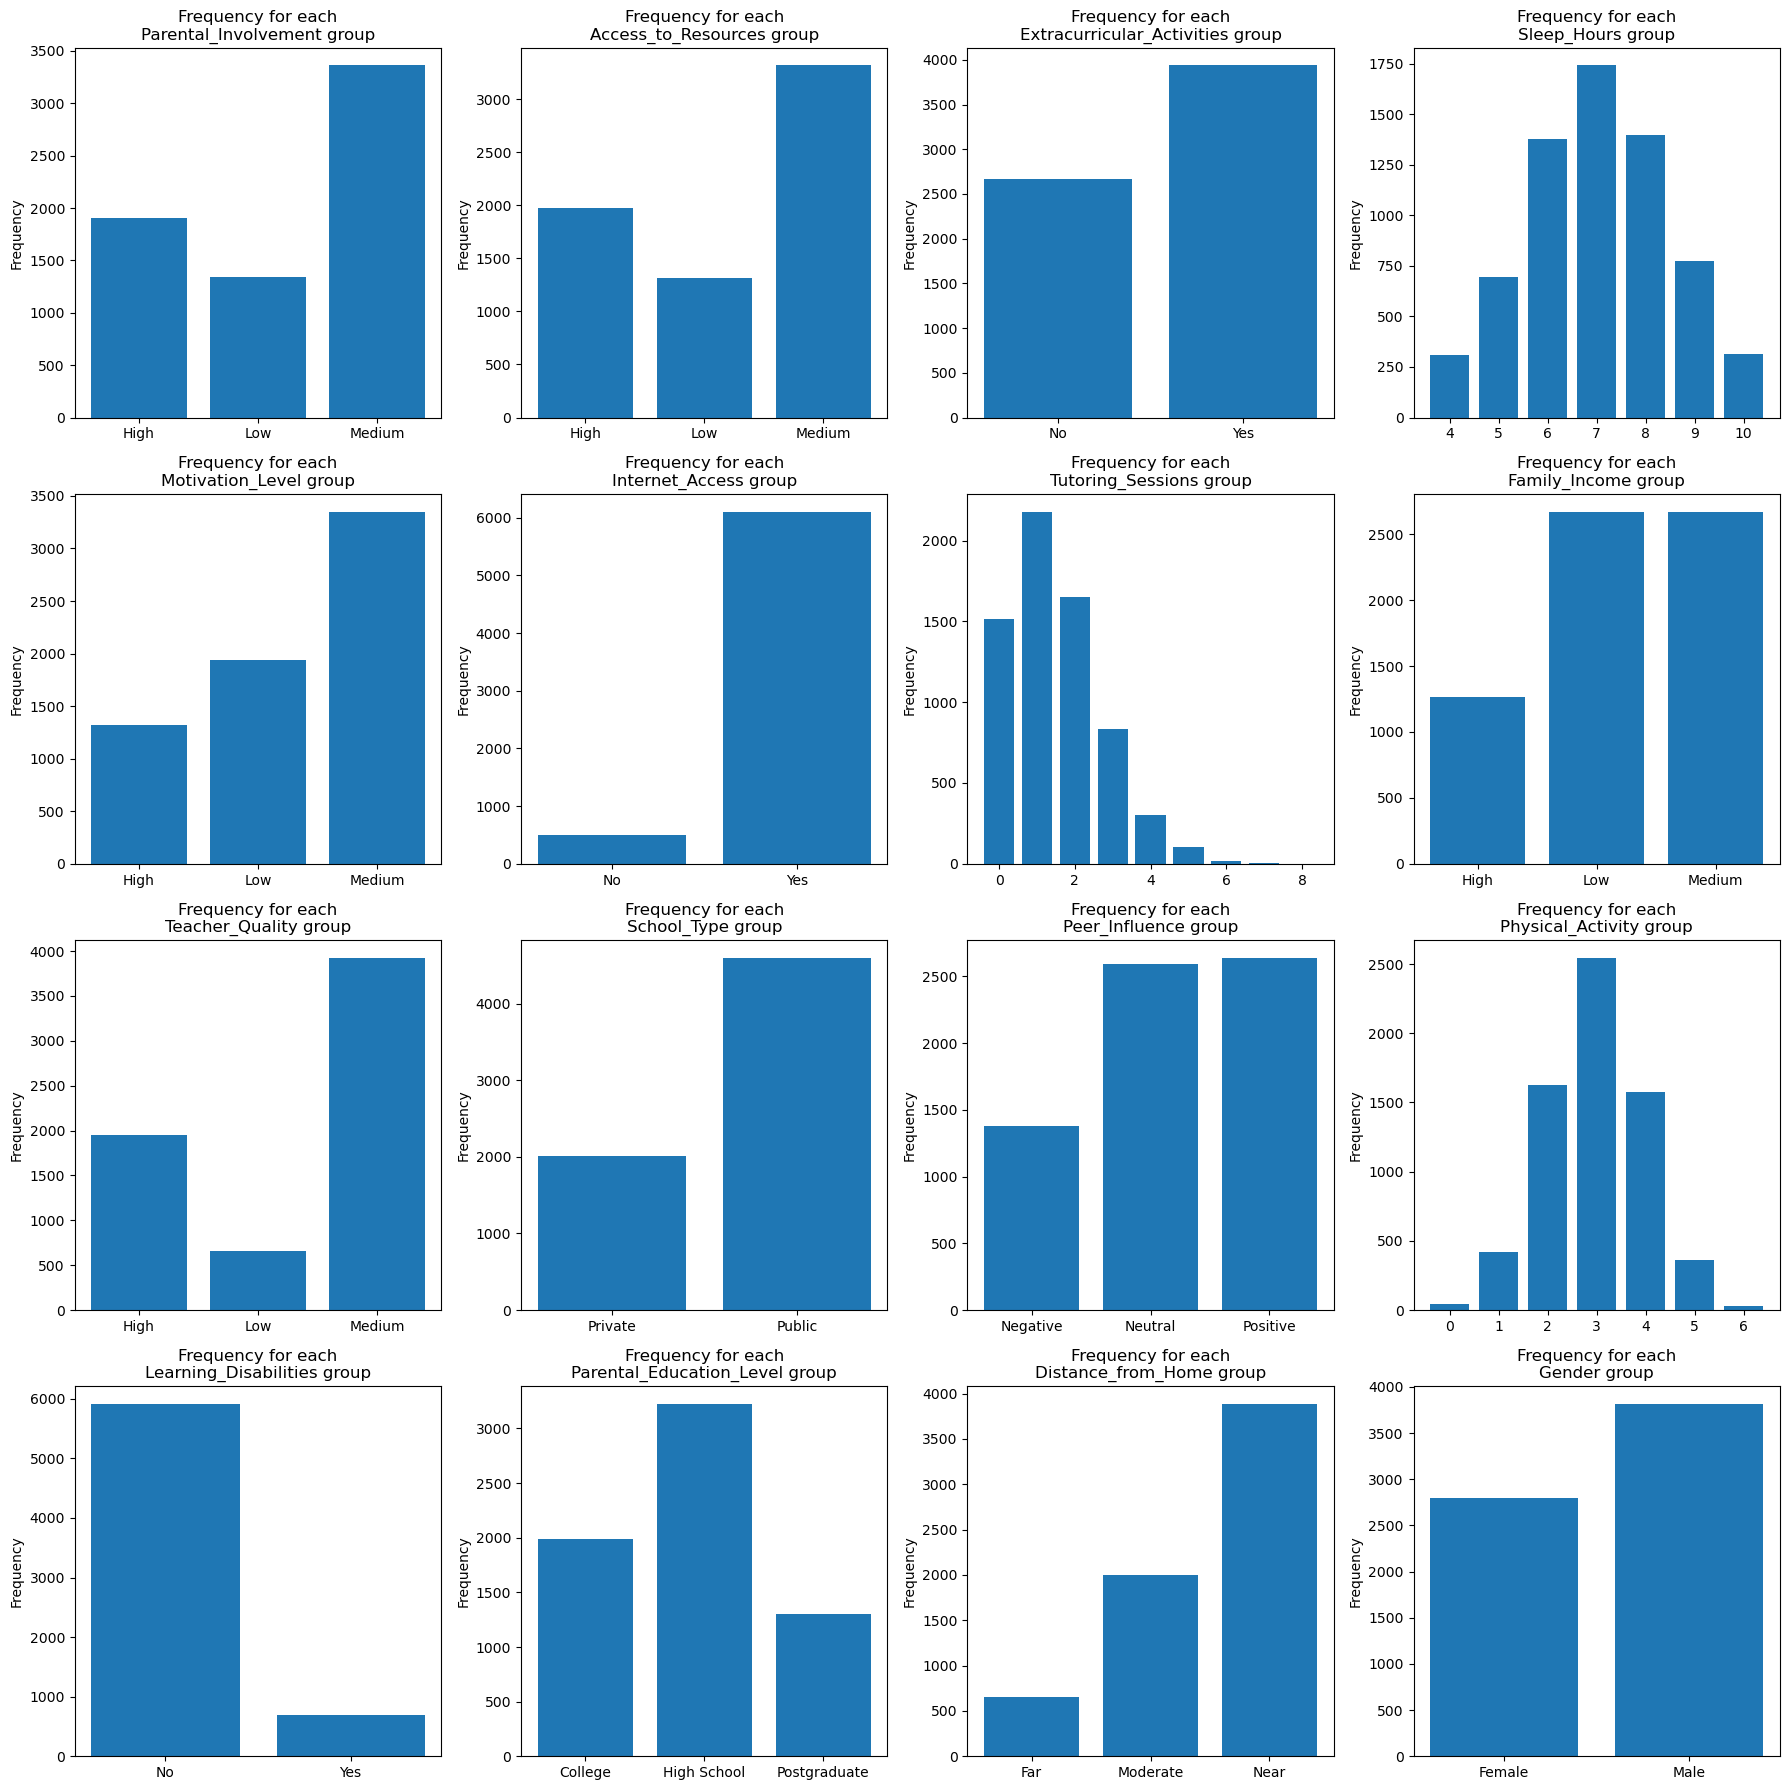

In [23]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(18,18))
ax = ax.flatten()

for i, colname in enumerate(categorical_variables):

    group = students.groupby(colname, observed=False).size()

    ax[i].bar(group.index, group)

    ax[i].set_ylabel('Frequency')
    ax[i].set_title(f"Frequency for each\n{colname} group")

plt.tight_layout()
plt.show()

##### Box plots

In [24]:
boxplots = [students_adjusted[colname].values for colname in categorical_variables]

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.

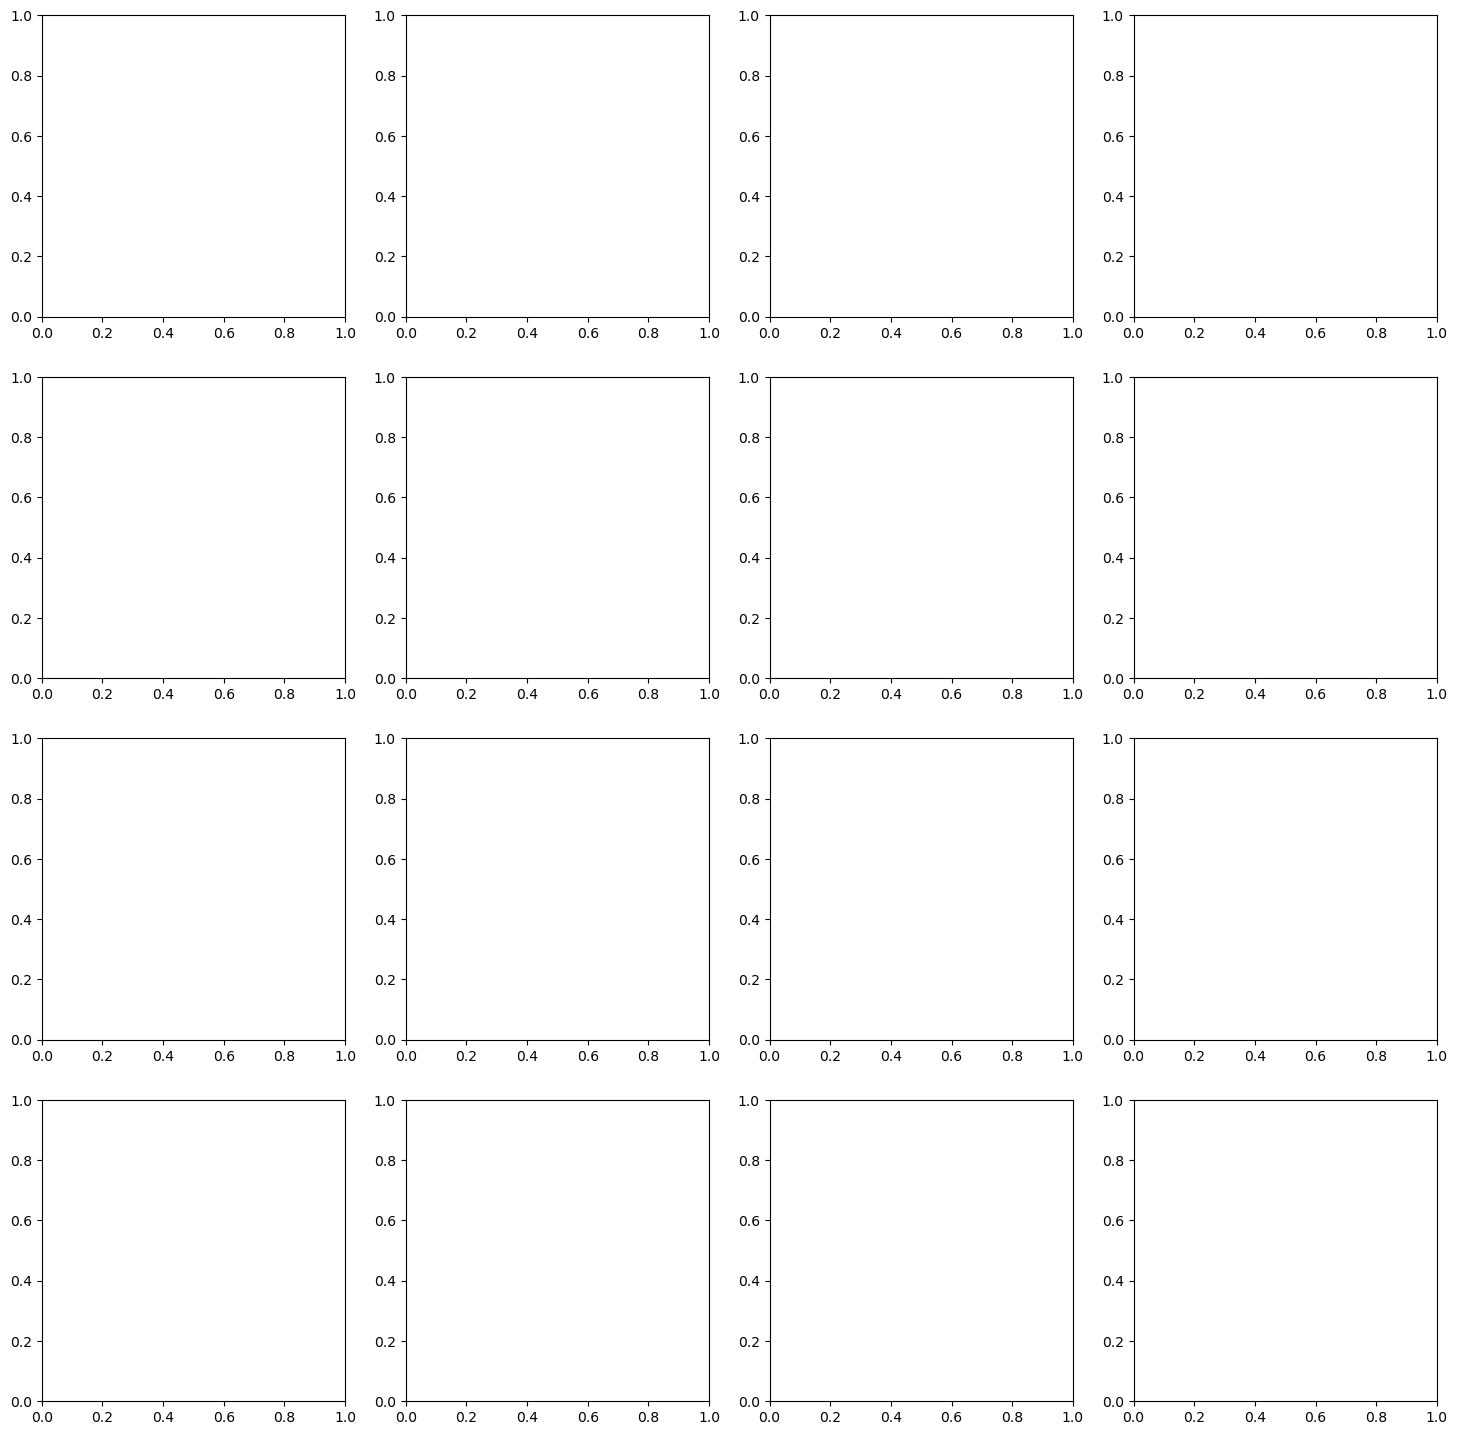

In [25]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(18,18))
ax = ax.flatten()

for i, colname in enumerate(categorical_variables):

    list_of_values = []
    for category in list(students_adjusted[colname].cat.categories):
        list_of_values.append(students_adjusted.loc[students_adjusted[colname]==category, colname].values)

    ax[i].boxplot(list_of_values)

    ax[i].set_title(f"Distribution for each\n{colname} group")

plt.tight_layout()
plt.show()

#### Numerical variables

##### Boxplots

findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.

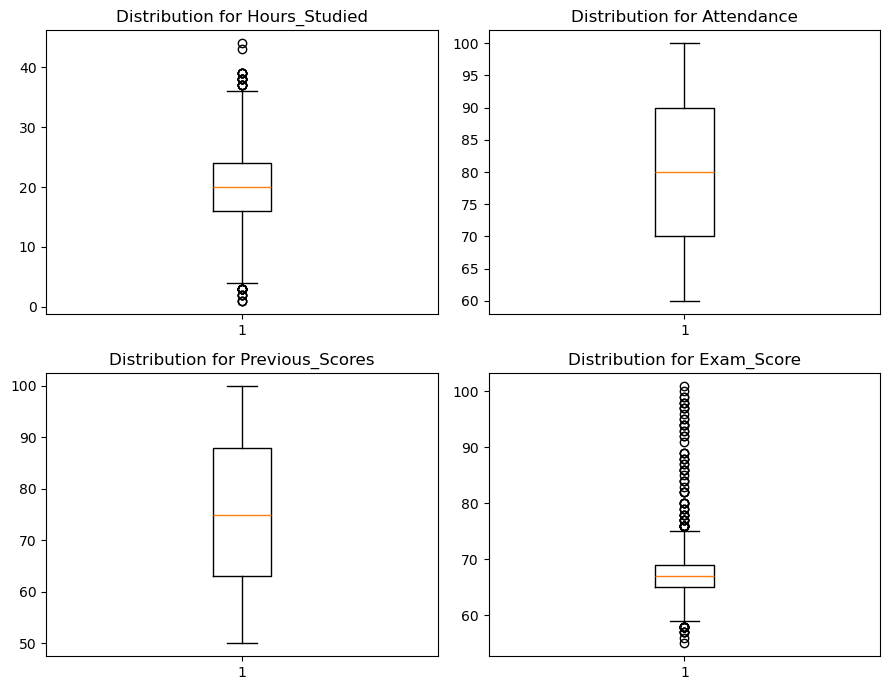

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(9,7))
ax = ax.flatten()

for i, colname in enumerate(numerical_variables):

    ax[i].boxplot(students_adjusted[colname])

    ax[i].set_title(f"Distribution for {colname}")

plt.tight_layout()
plt.show()

##### Pairwise plot

findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.

findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.
findfont: Font family "'sans-serif']" not found.
findfont: Font family "['Apple Color Emoji'" not found.

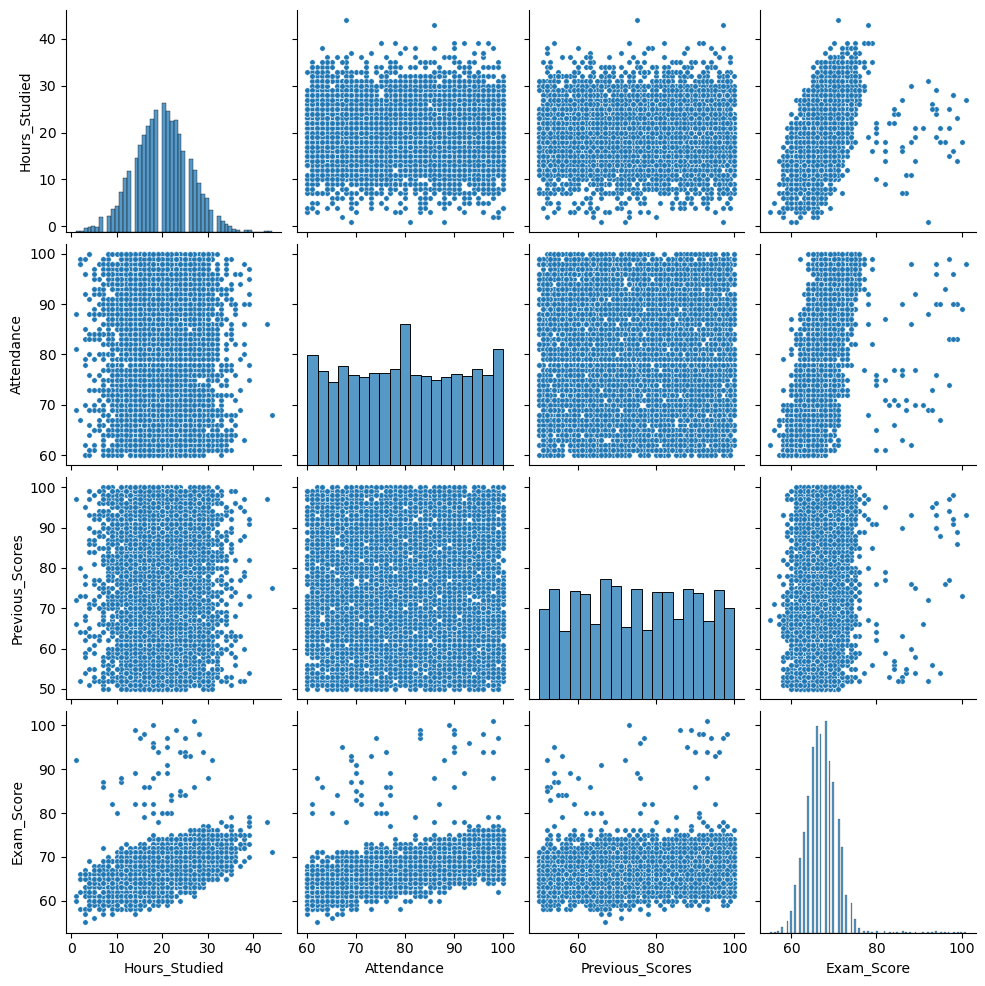

In [27]:
sns.pairplot(students_adjusted[numerical_variables], diag_kind='hist', plot_kws={'s': 15})

##### Correlation heatmap

In [28]:
## The clean dataset here is students_adjusted
students_adjusted.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [ ]:
## Here are the lists with categorical vairables vs. numeric variables:
print(f"Categorical variables: {categorical_variables}")
print(f"Numerical variables: {numerical_variables}")

Categorical variables: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Sleep_Hours', 'Motivation_Level', 'Internet_Access', 'Tutoring_Sessions', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Numerical variables: ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Exam_Score']


<div class="alert alert-block alert-danger">

_To compelete..._
**Chelyah**

</div>

## Our hypotheses

<div class="alert alert-block alert-danger">

_To compelete..._

</div>

<div class="alert alert-block alert-success">

**Our response variable will be: <kbd>Exam_Score</kbd>**

</div>

Let's define our final dataset to perform MLR on:

In [ ]:
performance = students_adjusted.copy()

In [ ]:
students_adjusted.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


# Model Selection

In [29]:
X = students_adjusted.drop('Exam_Score', axis= 1)
y = students_adjusted['Exam_Score']

In [31]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns


In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)  # drop='first' avoids dummy variable trap
    ]
)


In [48]:
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(alpha=0.2))  # You can adjust alpha for regularization
])

# Fit the model to the entire dataset
lasso_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Hours_Studied', 'Attendance', 'Previous_Scores'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Parental_Involvement', 'Access_to_Resources',
       'Extracurricular_Activities', 'Sleep_Hours', 'Motivation_Level',
       'Internet_Access', 'Tutoring_Sessions', 'Family_Income',
       'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Physical_Activity',
       'Learning_Disabilities', 'Parental_Education_Level',
       'Distance_from_Home', 'Gender'],
      dtype='object'))])),
                ('lasso', Lasso(alpha=0.2))])

In [49]:
# Get feature names after one-hot encoding
encoded_categorical_names = lasso_pipeline.named_steps['preprocessor'] \
    .transformers_[1][1].get_feature_names_out(categorical_cols)

# Combine numerical and encoded categorical column names
all_feature_names = list(numerical_cols) + list(encoded_categorical_names)

# Get the coefficients of the Lasso model
lasso_coefficients = lasso_pipeline.named_steps['lasso'].coef_

# Select features with non-zero coefficients
selected_features = [name for name, coef in zip(all_feature_names, lasso_coefficients) if coef != 0]

print(f'Selected predictors: {selected_features}')


Selected predictors: ['Hours_Studied', 'Attendance', 'Previous_Scores', 'Parental_Involvement_Low', 'Access_to_Resources_Low']


In [52]:
lasso_model = smf.ols('Exam_Score ~ Attendance + Previous_Scores + Parental_Involvement + Access_to_Resources', data = students_adjusted).fit()
lasso_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Exam_Score   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     797.3
Date:                Thu, 26 Sep 2024   Prob (F-statistic):               0.00
Time:                        10:28:42   Log-Likelihood:                -15967.
No. Observations:                6378   AIC:                         3.195e+04
Df Residuals:                    6371   BIC:                         3.199e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         49.3491      0.336    146.854      0.000      48.690      50.008
Parental_Involvement[T.Low]       -1.9050      0.108    -17.703      0.000      -2.116      -1.694
Parental_Involvement[T.Medium]    -1.0069      0.086    -11.651      0.000      -1.176      -0.837
Access_to_Resources[T.Low]        -1.9728      0.107    -18.391      0.000      -2.183      -1.762
Access_to_Resources[T.Medium]     -0.9579      0.086    -11.178      0.000      -1.126      -0.790
Attendance                         0.1989      0.003     61.985      0.000       0.193       0.205
Previous_Scores                    0.0500      0.003     19.433      0.000       0.045       0.055
==============================================================================
Omnibus:                     5376.815   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           267466.432
Skew:                           3.750   Prob(JB):                         0.00
Kurtosis:                      33.826   Cond. No.                     1.01e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/var/folders/9r/tnq8p07x6g717k6kdnjx4fq80000gn/T/ipykernel_1045/813586060.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


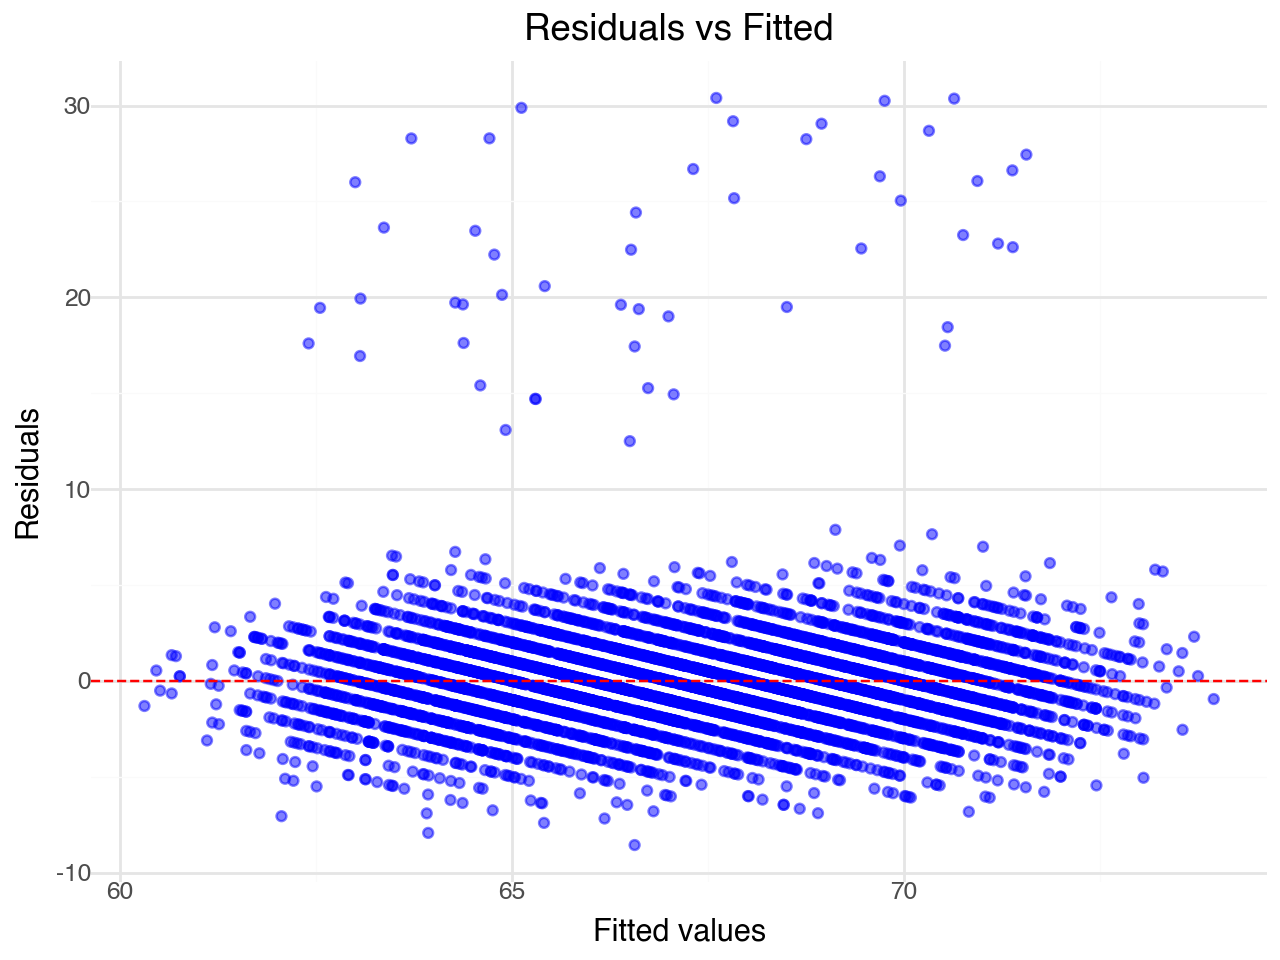

In [58]:
y_pred = lasso_model.predict(X)

# Calculate residuals
residuals = y - y_pred

# Create a DataFrame for plotting
df = pd.DataFrame({'Fitted': y_pred, 'Residuals': residuals})

# Plot residuals vs fitted values
p = (ggplot(df, aes(x='Fitted', y='Residuals')) +
     geom_point(color="blue", alpha=0.5) +
     geom_hline(yintercept=0, linetype='dashed', color='red') +
     labs(title="Residuals vs Fitted",
          x="Fitted values",
          y="Residuals") +
     theme_minimal())
print(p)

/var/folders/9r/tnq8p07x6g717k6kdnjx4fq80000gn/T/ipykernel_1045/67189802.py:14: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


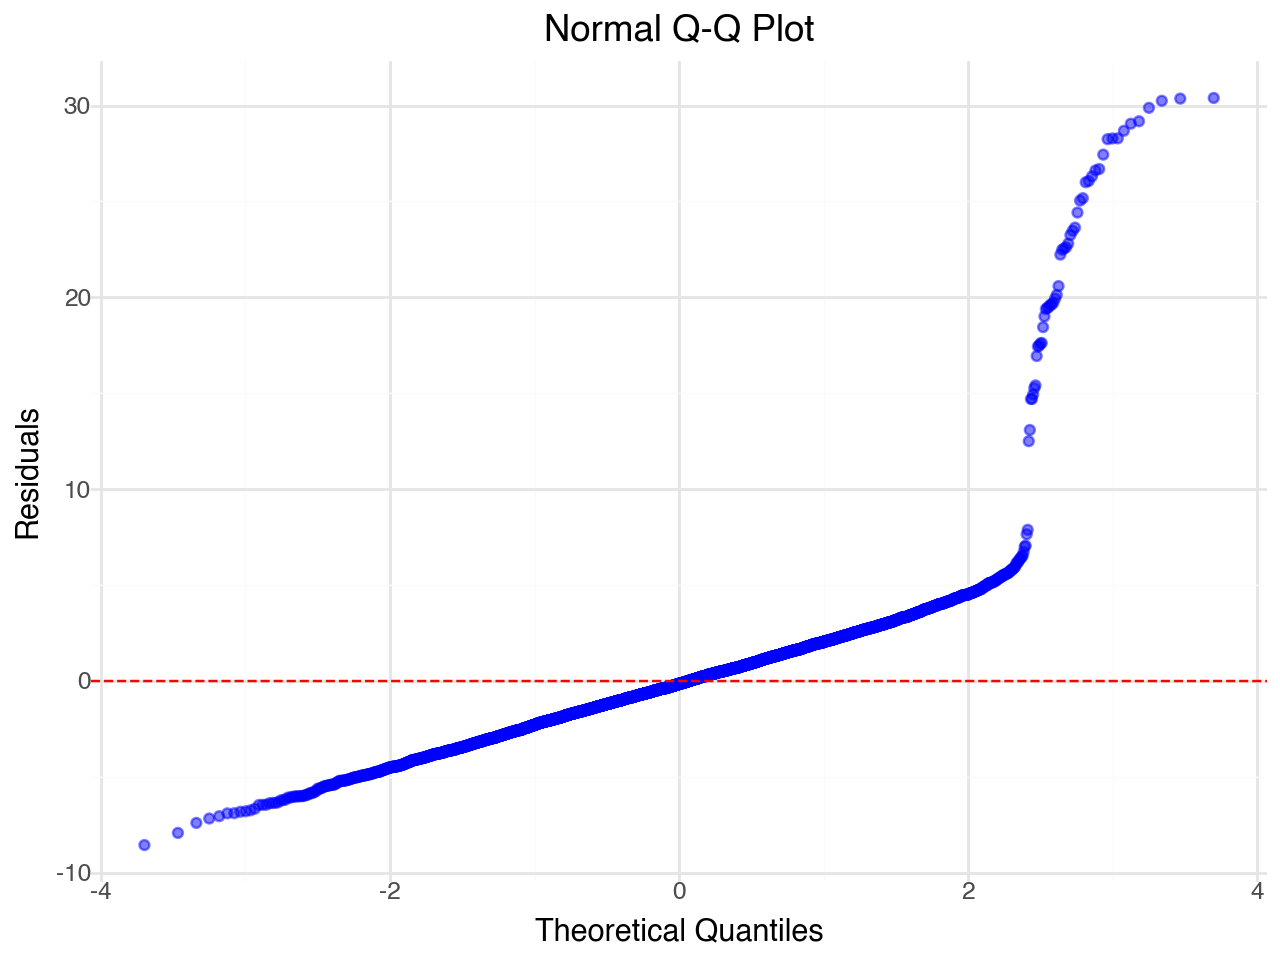

In [61]:
df['Residuals_sorted'] = np.sort(residuals)

# Theoretical quantiles
df['Theoretical_Quantiles'] = stats.probplot(residuals, dist="norm", plot=None)[0][0]

# Q-Q plot
p = (ggplot(df, aes(x='Theoretical_Quantiles', y='Residuals_sorted')) +
     geom_point(color="blue", alpha=0.5) +
     geom_hline(yintercept=0, linetype='dashed', color='red') +
     labs(title="Normal Q-Q Plot",
          x="Theoretical Quantiles",
          y="Residuals") +
     theme_minimal())
print(p)

In [65]:
df = pd.DataFrame({'X': X.squeeze(), 'y': y})

p = (ggplot(df, aes(x='X', y='y')) +
     geom_point(color='blue', alpha=0.6) +  # Scatter points
     geom_smooth(method='lm', se=False, color='red') +  # Regression line
     labs(title="Scatterplot with Regression Line",
          x="X",
          y="y") +
     theme_minimal())

print(p)

ValueError: 2

In [63]:
X_with_const = sm.add_constant(X)  # Add constant for intercept
ols_model = sm.OLS(y, X_with_const).fit()

influence = OLSInfluence(ols_model)

# Extract leverage and residuals
df['Leverage'] = influence.hat_matrix_diag
df['Standardized_Residuals'] = influence.resid_studentized_internal

# Plot: Standardized Residuals vs Leverage
p = (ggplot(df, aes(x='Leverage', y='Standardized_Residuals')) +
     geom_point(color="blue", alpha=0.5) +
     geom_hline(yintercept=0, linetype='dashed', color='red') +
     labs(title="Residuals vs Leverage",
          x="Leverage",
          y="Standardized Residuals") +
     theme_minimal())
print(p)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

## Multiple Regression Analysis